In [1]:
from core import *
import requests, json

In [2]:
dataset_id = {
    'all': 'd_8801ce23f7b9a0d20a795bf20a2c23b8', 
}
dataset_mode = 'all'

In [3]:
response = requests.get(
    'https://data.gov.sg/api/action/datastore_search', 
    params={
        'resource_id': dataset_id[dataset_mode],
        'limit': 999
    }
)
print(json.dumps(response.json(), indent=2))

{
  "help": "https://data.gov.sg/api/3/action/help_show?name=datastore_search",
  "success": true,
  "result": {
    "resource_id": "d_8801ce23f7b9a0d20a795bf20a2c23b8",
    "fields": [
      {
        "type": "text",
        "id": "DataSeries"
      },
      {
        "type": "numeric",
        "id": "2023"
      },
      {
        "type": "numeric",
        "id": "2022"
      },
      {
        "type": "numeric",
        "id": "2021"
      },
      {
        "type": "numeric",
        "id": "2020"
      },
      {
        "type": "numeric",
        "id": "2019"
      },
      {
        "type": "numeric",
        "id": "2018"
      },
      {
        "type": "numeric",
        "id": "2017"
      },
      {
        "type": "numeric",
        "id": "2016"
      },
      {
        "type": "numeric",
        "id": "2015"
      },
      {
        "type": "text",
        "id": "2014"
      },
      {
        "type": "text",
        "id": "2013"
      },
      {
        "type": "text",
     

In [4]:
data = response.json()
records = data['result']['records']
df = pd.DataFrame(records)
df['DataSeries'] = df['DataSeries'].str.strip()
df['DataSeries'] = df['DataSeries'].str.replace(r'(?i)\b(total)\b.*\b(bride|groom)s?\b', r'\2 \1', regex=True)
df[['SubDataSeries', 'SubSubDataSeries']] = df['DataSeries'].str.extract(r'(?i)\b(bride|groom)s?\b.*?\b(total|under.*|\d+.*)\b')
df['DataSeries'] = df['DataSeries'].str.replace(r'(?i).*\b(bride|groom)s?\b.*', r'Total', regex=True)
df['SubDataSeries'] = df['SubDataSeries'].ffill()
df['SubSubDataSeries'] = df['SubSubDataSeries'].ffill()
df['SubSubDataSeries'] = df['SubSubDataSeries'].str.replace(r'(?i)\W*\byears?\b|\s+', '', regex=True).str.replace(r'(?i)\W*over\b', '+', regex=True).str.strip()
df = df.rename(columns={'DataSeries': 'educ_lvl', 'SubDataSeries': 'gender', 'SubSubDataSeries': 'age_group'}).drop(columns=['_id'])
for col in df.drop(columns=['gender', 'age_group', 'educ_lvl']).columns:
    try:
        df[col] = df[col].astype('float')
    except:
        df[col] = df[col].str.strip().where(df[col].str.contains(r'\d+(?:\.\d+)?', na=False)).astype('float')
df = df.dropna(subset=df.loc[:,'1990':'2010'].columns, how='all')
df['gender'] = pd.Categorical(df['gender'], ['Bride', 'Groom'], ordered=False)
df['educ_lvl'] = pd.Categorical(df['educ_lvl'], ['Secondary & Below', 'Post-Secondary', 'University', 'Total'], ordered=False)
df['age_group'] = pd.Categorical(df['age_group'].replace({'Under20': '15-19'}), ['15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60+', 'Total'], ordered=True)
df = df.groupby(by=['gender', 'age_group', 'educ_lvl'], observed=True).sum().astype('int')
df = df.rename(columns=int).transpose().sort_index(axis=0).sort_index(axis=1).copy(deep=True)
assert isinstance(df, pd.DataFrame)
display_all_columns(df)

gender                Bride                                                    \
age_group             15-19                                             20-24   
educ_lvl  Secondary & Below Post-Secondary University Total Secondary & Below   
1984                   1108              4          0  1112              7436   
1985                   1014             10          0  1024              6887   
1986                    774              4          0   778              5316   
1987                    779             11          0   790              5977   
1988                    704              8          0   712              6226   
1989                    656             12          0   668              5226   
1990                    641             20          0   661              4626   
1991                    600             16          0   616              4447   
1992                    595              8          0   603              4009   
1993                    461             12          0   473              3663   
1994                    405             10          0   415              3524   
1995                    353             14          0   367              3323   
1996                    344             14          0   358              2839   
1997                    332              7          0   339              3284   
1998                    404             12          0   416              2129   
1999                    393             16          0   409              2251   
2000                    367             18          0   385              1620   
2001                    335             17          0   352              1511   
2002                    266             21          0   287              1406   
2003                    206             26          0   232              1002   
2004                    168             55          0   223               791   
2005                    161             59          0   220               682   
2006                    142             60          0   202               636   
2007                    169             62          0   231               489   
2008                    133             55          0   188               455   
2009                    124             47          2   173               395   
2010                    135             53          1   189               313   
2011                    109             50          0   159               379   
2012                     97             38          0   135               414   
2013                     86             51          1   138               298   
2014                     55             26          2    83               304   
2015                     49             18          0    67               234   
2016                     51             26          0    77               217   
2017                     45             20          0    65               187   
2018                     30             16          0    46               152   
2019                     25             17          1    43               149   
2020                     32             15          0    47               134   
2021                     26             12          0    38               131   
2022                     24             17          0    41               103   
2023                     20             12          2    34               103   

gender                                                                      \
age_group                                             25-29                  
educ_lvl  Post-Secondary University Total Secondary & Below Post-Secondary   
1984                 878        176  8490              4542           1064   
1985                 794        201  7882              4235           1008   
1986                 598        155  6069              3294            924   
1987                 756        219  6952       

In [ ]:
df_pct_educ = df.apply(lambda row: row.div(row.xs('Total', 0, 'age_group')), axis=1).drop(columns=['Total'], level='age_group').drop(columns=['Total'], level='educ_lvl').sort_index(axis=1).sort_index(axis=0).copy(deep=True)
display_all_columns(df_pct_educ)

gender                Bride                                              \
age_group             15-19                                       20-24   
educ_lvl  Secondary & Below Post-Secondary University Secondary & Below   
1984               0.074986       0.001875   0.000000          0.503249   
1985               0.073665       0.005003   0.000000          0.500327   
1986               0.070569       0.002322   0.000000          0.484683   
1987               0.059416       0.004931   0.000000          0.455877   
1988               0.052021       0.003075   0.000000          0.460061   
1989               0.054404       0.004868   0.000000          0.433405   
1990               0.054688       0.007405   0.000000          0.394676   
1991               0.051147       0.004988   0.000000          0.379081   
1992               0.054547       0.002259   0.000000          0.367528   
1993               0.045298       0.003230   0.000000          0.359929   
1994               0.042404       0.002660   0.000000          0.368967   
1995               0.039734       0.003431   0.000000          0.374043   
1996               0.042669       0.003549   0.000000          0.352146   
1997               0.038126       0.001505   0.000000          0.377124   
1998               0.060788       0.003134   0.000000          0.320343   
1999               0.055516       0.003368   0.000000          0.317983   
2000               0.066534       0.004577   0.000000          0.293691   
2001               0.067040       0.004700   0.000000          0.302381   
2002               0.057315       0.004993   0.000000          0.302952   
2003               0.054904       0.006335   0.000000          0.267058   
2004               0.052780       0.013723   0.000000          0.248508   
2005               0.054968       0.015234   0.000000          0.232844   
2006               0.049426       0.014218   0.000000          0.221371   
2007               0.066431       0.014643   0.000000          0.192217   
2008               0.055118       0.013095   0.000000          0.188562   
2009               0.052587       0.010626   0.000265          0.167515   
2010               0.067198       0.014375   0.000137          0.155799   
2011               0.050300       0.012005   0.000000          0.174896   
2012               0.046190       0.009128   0.000000          0.197143   
2013               0.050529       0.013791   0.000126          0.175088   
2014               0.030270       0.006636   0.000216          0.167309   
2015               0.033401       0.004321   0.000000          0.159509   
2016               0.036507       0.006667   0.000000          0.155333   
2017               0.034803       0.005202   0.000000          0.144625   
2018               0.025489       0.004585   0.000000          0.129142   
2019               0.022645       0.005273   0.000106          0.134964   
2020               0.038232       0.005185   0.000000          0.160096   
2021               0.026887       0.003435   0.000000          0.135471   
2022               0.024267       0.004561   0.000000          0.104146   
2023               0.020346       0.003503   0.000166          0.104781   

gender                                                                \
age_group                                       25-29                  
educ_lvl  Post-Secondary University Secondary & Below Post-Secondary   
1984            0.411627   0.226512          0.307390       0.498828   
1985            0.397199   0.231034          0.307664       0.504252   
1986            0.347069   0.178161          0.300328       0.536274   
1987            0.338861   0.195536          0.329952       0.518153   
1988            0.353958   0.221828          0.329786       0.510377   
1989            0.362272   0.197865          0.333306       0.469777   
1990            0.352832   0.174863          0.355174       0.485006   
1991            0.388092   0.197212          0.361521 

In [5]:
df_pct_age = df.apply(lambda row: row.div(row.xs('Total', 0, 'educ_lvl')), axis=1).drop(columns=['Total'], level='age_group').drop(columns=['Total'], level='educ_lvl').sort_index(axis=1).sort_index(axis=0).copy(deep=True)
display_all_columns(df_pct_age)

gender                Bride                                              \
age_group             15-19                                       20-24   
educ_lvl  Secondary & Below Post-Secondary University Secondary & Below   
1984               0.996403       0.003597   0.000000          0.875854   
1985               0.990234       0.009766   0.000000          0.873763   
1986               0.994859       0.005141   0.000000          0.875927   
1987               0.986076       0.013924   0.000000          0.859753   
1988               0.988764       0.011236   0.000000          0.834584   
1989               0.982036       0.017964   0.000000          0.816945   
1990               0.969743       0.030257   0.000000          0.788478   
1991               0.974026       0.025974   0.000000          0.732137   
1992               0.986733       0.013267   0.000000          0.698067   
1993               0.974630       0.025370   0.000000          0.657748   
1994               0.975904       0.024096   0.000000          0.652472   
1995               0.961853       0.038147   0.000000          0.616626   
1996               0.960894       0.039106   0.000000          0.592199   
1997               0.979351       0.020649   0.000000          0.573424   
1998               0.971154       0.028846   0.000000          0.508965   
1999               0.960880       0.039120   0.000000          0.465467   
2000               0.953247       0.046753   0.000000          0.433271   
2001               0.951705       0.048295   0.000000          0.426354   
2002               0.926829       0.073171   0.000000          0.389798   
2003               0.887931       0.112069   0.000000          0.330911   
2004               0.753363       0.246637   0.000000          0.287846   
2005               0.731818       0.268182   0.000000          0.282870   
2006               0.702970       0.297030   0.000000          0.263900   
2007               0.731602       0.268398   0.000000          0.232636   
2008               0.707447       0.292553   0.000000          0.237598   
2009               0.716763       0.271676   0.011561          0.210106   
2010               0.714286       0.280423   0.005291          0.205381   
2011               0.685535       0.314465   0.000000          0.227355   
2012               0.718519       0.281481   0.000000          0.229745   
2013               0.623188       0.369565   0.007246          0.201897   
2014               0.662651       0.313253   0.024096          0.212439   
2015               0.731343       0.268657   0.000000          0.178899   
2016               0.662338       0.337662   0.000000          0.180233   
2017               0.692308       0.307692   0.000000          0.159829   
2018               0.652174       0.347826   0.000000          0.139578   
2019               0.581395       0.395349   0.023256          0.161605   
2020               0.680851       0.319149   0.000000          0.164619   
2021               0.684211       0.315789   0.000000          0.150402   
2022               0.585366       0.414634   0.000000          0.127792   
2023               0.588235       0.352941   0.058824          0.134641   

gender                                                                \
age_group                                       25-29                  
educ_lvl  Post-Secondary University Secondary & Below Post-Secondary   
1984            0.103416   0.020730          0.746058       0.174770   
1985            0.100736   0.025501          0.731686       0.174153   
1986            0.098534   0.025540          0.688114       0.193023   
1987            0.108746   0.031502          0.698869       0.186753   
1988            0.123458   0.041957          0.668514       0.198922   
1989            0.139597   0.043458          0.658960       0.189867   
1990            0.162434   0.049088          0.631619       0.198756   
1991            0.204972   0.062891          0.605511 

In [7]:
df_cohort_educ = df_pct_educ.rename_axis(index='year').stack(level=['age_group', 'educ_lvl']).reset_index(drop=False).copy(deep=True)
df_cohort_educ['cohort'] = df_cohort_educ['age_group'].str.extract(r'(?i)(\d+)')
df_cohort_educ['cohort'] = df_cohort_educ['year'].subtract(df_cohort_educ['cohort'].astype('int')).map(lambda val: f'{val-4:.0f}-{val:.0f}')
for col in ['age_group']:
    df_cohort_educ[col] = pd.Categorical(df_cohort_educ[col], df_cohort_educ[col].sort_values().unique(), ordered=True)
df_cohort_educ = df_cohort_educ.drop(columns=['year']).set_index(keys=['cohort', 'age_group', 'educ_lvl'], append=False).sort_index(axis=1).sort_index(axis=0).copy(deep=True)
df_cohort_educ = df_cohort_educ.T.stack(level=['age_group']).unstack(level=['gender']).sort_index(axis=1).sort_index(axis=0).copy(deep=True)
display_all_columns(df_cohort_educ)

/tmp/ipykernel_4222/2916468962.py:1: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df_cohort_educ = df_pct_educ.rename_axis(index='year').stack(level=['age_group', 'educ_lvl']).reset_index(drop=False).copy(deep=True)
/tmp/ipykernel_4222/2916468962.py:7: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df_cohort_educ = df_cohort_educ.T.stack(level=['age_group']).unstack(level=['gender']).sort_index(axis=1).sort_index(axis=0).copy(deep=True)


cohort            1920-1924                                            \
educ_lvl  Secondary & Below           Post-Secondary       University   
gender                Bride     Groom          Bride Groom      Bride   
age_group                                                               
15-19                   NaN       NaN            NaN   NaN        NaN   
20-24                   NaN       NaN            NaN   NaN        NaN   
25-29                   NaN       NaN            NaN   NaN        NaN   
30-34                   NaN       NaN            NaN   NaN        NaN   
35-39                   NaN       NaN            NaN   NaN        NaN   
40-44                   NaN       NaN            NaN   NaN        NaN   
45-49                   NaN       NaN            NaN   NaN        NaN   
50-54                   NaN       NaN            NaN   NaN        NaN   
55-59                   NaN       NaN            NaN   NaN        NaN   
60+                0.000406  0.001886            0.0   0.0        0.0   

cohort                      1921-1925                                     \
educ_lvl            Secondary & Below           Post-Secondary             
gender        Groom             Bride     Groom          Bride     Groom   
age_group                                                                  
15-19           NaN               NaN       NaN            NaN       NaN   
20-24           NaN               NaN       NaN            NaN       NaN   
25-29           NaN               NaN       NaN            NaN       NaN   
30-34           NaN               NaN       NaN            NaN       NaN   
35-39           NaN               NaN       NaN            NaN       NaN   
40-44           NaN               NaN       NaN            NaN       NaN   
45-49           NaN               NaN       NaN            NaN       NaN   
50-54           NaN               NaN       NaN            NaN       NaN   
55-59           NaN               NaN       NaN            NaN       NaN   
60+        0.000694          0.000218  0.001581            0.0  0.001108   

cohort                                 1922-1926                           \
educ_lvl  University           Secondary & Below           Post-Secondary   
gender         Bride     Groom             Bride     Groom          Bride   
age_group                                                                   
15-19            NaN       NaN               NaN       NaN            NaN   
20-24            NaN       NaN               NaN       NaN            NaN   
25-29            NaN       NaN               NaN       NaN            NaN   
30-34            NaN       NaN               NaN       NaN            NaN   
35-39            NaN       NaN               NaN       NaN            NaN   
40-44            NaN       NaN               NaN       NaN            NaN   
45-49            NaN       NaN               NaN       NaN            NaN   
50-54            NaN       NaN               NaN       NaN            NaN   
55-59            NaN       NaN               NaN       NaN            NaN   
60+              0.0  0.000671               0.0  0.002117            0.0   

cohort                                           1923-1927            \
educ_lvl            University           Secondary & Below             
gender        Groom      Bride     Groom             Bride     Groom   
age_group                                                              
15-19           NaN        NaN       NaN               NaN       NaN   
20-24           NaN        NaN       NaN               NaN       NaN   
25-29           NaN        NaN       NaN               NaN       NaN   
30-34           NaN        NaN       NaN               NaN       NaN   
35-39           NaN        NaN       NaN               NaN       NaN   
40-44           NaN        NaN       NaN               NaN       NaN   
45-49           NaN        NaN       NaN               NaN       NaN   
50-54           NaN        NaN       NaN 

In [8]:
df_cohort_age = df_pct_age.rename_axis(index='year').stack(level=['age_group', 'educ_lvl']).reset_index(drop=False).copy(deep=True)
df_cohort_age['cohort'] = df_cohort_age['age_group'].str.extract(r'(?i)(\d+)')
df_cohort_age['cohort'] = df_cohort_age['year'].subtract(df_cohort_age['cohort'].astype('int')).map(lambda val: f'{val-4:.0f}-{val:.0f}')
for col in ['age_group']:
    df_cohort_age[col] = pd.Categorical(df_cohort_age[col], df_cohort_age[col].sort_values().unique(), ordered=True)
df_cohort_age = df_cohort_age.drop(columns=['year']).set_index(keys=['cohort', 'age_group', 'educ_lvl'], append=False).sort_index(axis=1).sort_index(axis=0).copy(deep=True)
df_cohort_age = df_cohort_age.T.stack(level=['age_group']).unstack(level=['gender']).sort_index(axis=1).sort_index(axis=0).copy(deep=True)
display_all_columns(df_cohort_age)

/tmp/ipykernel_4222/3889413801.py:1: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df_cohort_age = df_pct_age.rename_axis(index='year').stack(level=['age_group', 'educ_lvl']).reset_index(drop=False).copy(deep=True)
/tmp/ipykernel_4222/3889413801.py:7: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df_cohort_age = df_cohort_age.T.stack(level=['age_group']).unstack(level=['gender']).sort_index(axis=1).sort_index(axis=0).copy(deep=True)


cohort            1920-1924                                            \
educ_lvl  Secondary & Below           Post-Secondary       University   
gender                Bride     Groom          Bride Groom      Bride   
age_group                                                               
15-19                   NaN       NaN            NaN   NaN        NaN   
20-24                   NaN       NaN            NaN   NaN        NaN   
25-29                   NaN       NaN            NaN   NaN        NaN   
30-34                   NaN       NaN            NaN   NaN        NaN   
35-39                   NaN       NaN            NaN   NaN        NaN   
40-44                   NaN       NaN            NaN   NaN        NaN   
45-49                   NaN       NaN            NaN   NaN        NaN   
50-54                   NaN       NaN            NaN   NaN        NaN   
55-59                   NaN       NaN            NaN   NaN        NaN   
60+                     1.0  0.964286            0.0   0.0        0.0   

cohort                      1921-1925                                        \
educ_lvl            Secondary & Below       Post-Secondary       University   
gender        Groom             Bride Groom          Bride Groom      Bride   
age_group                                                                     
15-19           NaN               NaN   NaN            NaN   NaN        NaN   
20-24           NaN               NaN   NaN            NaN   NaN        NaN   
25-29           NaN               NaN   NaN            NaN   NaN        NaN   
30-34           NaN               NaN   NaN            NaN   NaN        NaN   
35-39           NaN               NaN   NaN            NaN   NaN        NaN   
40-44           NaN               NaN   NaN            NaN   NaN        NaN   
45-49           NaN               NaN   NaN            NaN   NaN        NaN   
50-54           NaN               NaN   NaN            NaN   NaN        NaN   
55-59           NaN               NaN   NaN            NaN   NaN        NaN   
60+        0.035714               1.0  0.84            0.0  0.12        0.0   

cohort                  1922-1926                                     \
educ_lvl        Secondary & Below           Post-Secondary             
gender    Groom             Bride     Groom          Bride     Groom   
age_group                                                              
15-19       NaN               NaN       NaN            NaN       NaN   
20-24       NaN               NaN       NaN            NaN       NaN   
25-29       NaN               NaN       NaN            NaN       NaN   
30-34       NaN               NaN       NaN            NaN       NaN   
35-39       NaN               NaN       NaN            NaN       NaN   
40-44       NaN               NaN       NaN            NaN       NaN   
45-49       NaN               NaN       NaN            NaN       NaN   
50-54       NaN               NaN       NaN            NaN       NaN   
55-59       NaN               NaN       NaN            NaN       NaN   
60+        0.04               NaN  0.741935            NaN  0.193548   

cohort                                 1923-1927                           \
educ_lvl  University           Secondary & Below           Post-Secondary   
gender         Bride     Groom             Bride     Groom          Bride   
age_group                                                                   
15-19            NaN       NaN               NaN       NaN            NaN   
20-24            NaN       NaN               NaN       NaN            NaN   
25-29            NaN       NaN               NaN       NaN            NaN   
30-34            NaN       NaN               NaN       NaN            NaN   
35-39            NaN       NaN               NaN       NaN            NaN   
40-44            NaN       NaN               NaN       NaN            NaN   
45-49            NaN       NaN               NaN       NaN            NaN   
50-54         

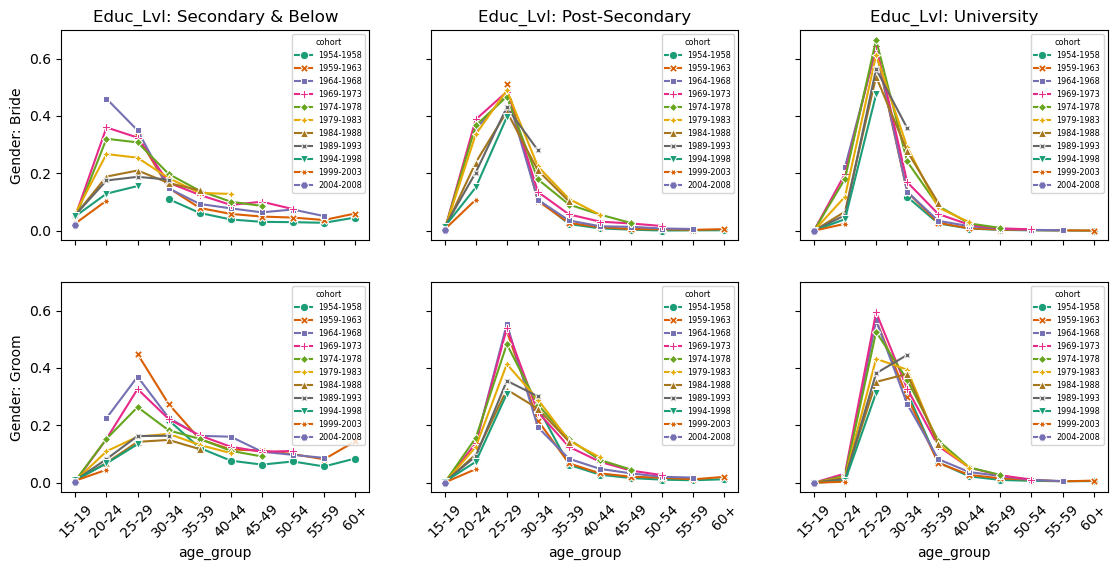

In [9]:
fig, axs = plot_multicol_data(df_cohort_educ.loc[:,df_cohort_educ.xs(('Bride', 'University', ), 1, ('gender', 'educ_lvl', )).iloc[:,-51::5].columns], x_level='gender', y_level='educ_lvl')
fig.savefig(f'./age_educ_{dataset_mode}.svg', transparent=False, format='svg', bbox_inches='tight')
plt.show()
fig.clf()
plt.close()

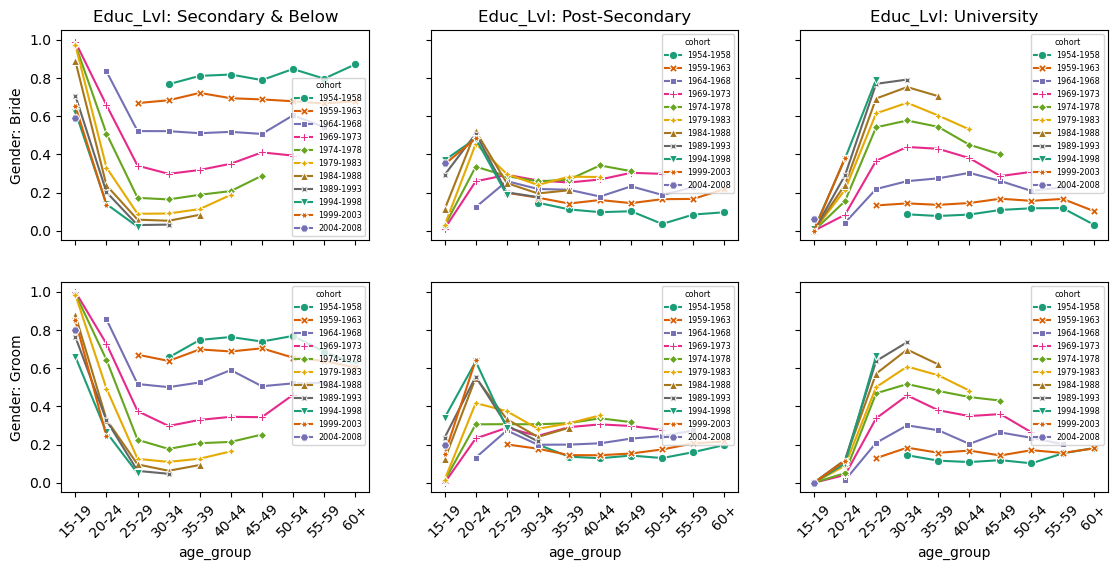

In [10]:
fig, axs = plot_multicol_data(df_cohort_age.loc[:,df_cohort_age.xs(('Bride', 'University', ), 1, ('gender', 'educ_lvl', )).iloc[:,-51::5].columns], x_level='gender', y_level='educ_lvl')
# fig.savefig(f'./age_educ_{dataset_mode}.svg', transparent=False, format='svg', bbox_inches='tight')
plt.show()
fig.clf()
plt.close()